**Librerías**

In [1]:
import numpy as np
from google.colab import drive
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

**Cargar el dataset**

In [2]:
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/PLN/PRÁCTICA FINAL/profesion/"

Mounted at /content/drive


In [3]:
df = pd.read_csv(PATH+"politicES_phase_2_train_public.csv") 
print('dataset cargado:', df.shape)
df.head()

dataset cargado: (180000, 6)


,label,gender,profession,ideology_binary,ideology_multiclass,tweet
0,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,¡Feliz 28 de febrero a todas las andaluzas y a...
1,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,"Feliz año nuevo, feliz esperanza 💕. Querido 20..."
2,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,🇩🇪🇪🇸 ¡Un placer encontrarme con mi homólogo al...
3,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,El conflicto en Ucrania ha supuesto una dramát...
4,0008c4fab9e97623a60380ee9c88cb20,female,politician,left,left,La Academia de la Llingua Asturiana realiza un...


**Para la clasificación multiclase me quedo solamente con los campos "tweet" y "ideology_multiclass"**

In [4]:
df_cb=df[['tweet', 'profession']].rename(columns={'tweet': 'text', 'profession': 'label'})
df_cb.head()

,text,label
0,¡Feliz 28 de febrero a todas las andaluzas y a...,politician
1,"Feliz año nuevo, feliz esperanza 💕. Querido 20...",politician
2,🇩🇪🇪🇸 ¡Un placer encontrarme con mi homólogo al...,politician
3,El conflicto en Ucrania ha supuesto una dramát...,politician
4,La Academia de la Llingua Asturiana realiza un...,politician


**Crear particiones**

In [5]:
# quitar las siguientes 4 líneas para coger todos los datos
parte_test = 0.6
df_train, df_aux = np.split(df_cb, [int((1 - parte_test) * len(df))])
X=df_train['text'] 
y=df_train['label']

#X=df_cb['text'] 
#y=df_cb['label']

X_train, X_aux, y_train, y_aux = train_test_split(X, y, 
        test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, 
        test_size=0.5, random_state=42, stratify=y_aux)

print('Tamaño conjunto de entrenamiento:', len(X_train))
print('Tamaño conjunto de validación:', len(X_val))
print('Tamaño conjunto de evaluación:', len(X_test))

Tamaño conjunto de entrenamiento: 50400
Tamaño conjunto de validación: 10800
Tamaño conjunto de evaluación: 10800


**Distribución de las clases**

In [6]:
counts_train = y_train.value_counts().to_dict()
print("Distribución en training:", counts_train)
counts_val = y_val.value_counts().to_dict()
print("Distribución en validación:", counts_val)
counts_test = y_test.value_counts().to_dict()
print("Distribución en test:", counts_test)

LABELS=counts_train.keys()
print(LABELS)

Distribución en training: {'journalist': 31024, 'politician': 16744, 'celebrity': 2632}
Distribución en validación: {'journalist': 6648, 'politician': 3588, 'celebrity': 564}
Distribución en test: {'journalist': 6648, 'politician': 3588, 'celebrity': 564}
dict_keys(['journalist', 'politician', 'celebrity'])


Text(0, 0.5, 'Número de Instancias')

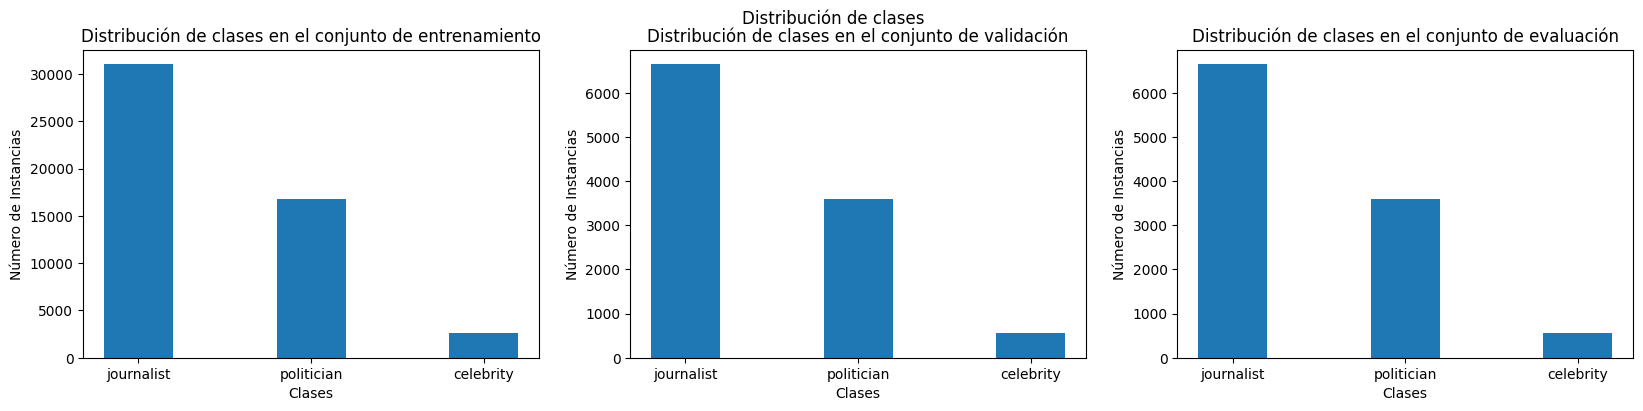

In [7]:
fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución de clases')
ax_train.bar(LABELS, counts_train.values(), width=0.4)
ax_train.set_title('Distribución de clases en el conjunto de entrenamiento')
ax_train.set_xlabel('Clases')
ax_train.set_ylabel('Número de Instancias')

ax_val.bar(LABELS, counts_val.values(), width=0.4)
ax_val.set_title('Distribución de clases en el conjunto de validación')
ax_val.set_xlabel('Clases')
ax_val.set_ylabel('Número de Instancias')


ax_test.bar(LABELS, counts_test.values(), width=0.4)
ax_test.set_title('Distribución de clases en el conjunto de evaluación')
ax_test.set_xlabel('Clases')
ax_test.set_ylabel('Número de Instancias')

**Distribución del tamaño de los textos**

In [8]:
length_train=X_train.apply(lambda text: len(text.split()))
length_train.describe()

count    50400.000000
mean        28.693948
std         12.763021
min          4.000000
25%         17.000000
50%         28.000000
75%         40.000000
max         62.000000
Name: text, dtype: float64

In [9]:
length_train.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    50400.000000
mean        28.693948
std         12.763021
min          4.000000
25%         17.000000
50%         28.000000
75%         40.000000
90%         46.000000
95%         48.000000
99%         52.000000
max         62.000000
Name: text, dtype: float64

In [10]:
length_val=X_val.apply(lambda text: len(text.split()))
length_val.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    10800.000000
mean        28.864352
std         12.708782
min          5.000000
25%         17.000000
50%         28.000000
75%         41.000000
90%         46.000000
95%         48.000000
99%         52.000000
max         60.000000
Name: text, dtype: float64

In [11]:
length_test=X_test.apply(lambda text: len(text.split()))
length_test.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

count    10800.000000
mean        29.037222
std         12.681212
min          4.000000
25%         17.000000
50%         29.000000
75%         41.000000
90%         46.000000
95%         48.000000
99%         52.000000
max         61.000000
Name: text, dtype: float64

Text(0, 0.5, 'Número de textos')

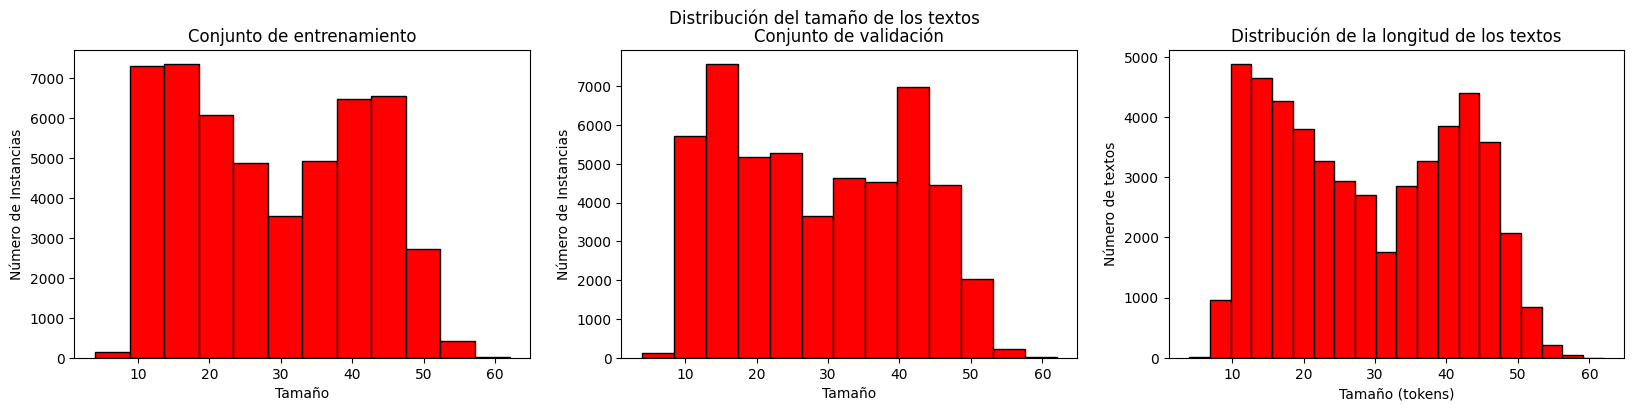

In [12]:
fig, (ax_train, ax_val, ax_test) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Distribución del tamaño de los textos')

ax_train.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(600/50))
ax_train.set_title('Conjunto de entrenamiento')
ax_train.set_xlabel('Tamaño')
ax_train.set_ylabel('Número de Instancias')

ax_val.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(200/15))
ax_val.set_title('Conjunto de validación')
ax_val.set_xlabel('Tamaño')
ax_val.set_ylabel('Número de Instancias')

ax_test.hist(length_train,  color = 'red', edgecolor = 'black',
         bins = int(300/15))
ax_test.set_title('Conjunto test')
ax_test.set_xlabel('Tamaño')
ax_test.set_ylabel('Número de Instancias')

# Add labels
plt.title('Distribución de la longitud de los textos')
plt.xlabel('Tamaño (tokens)')
plt.ylabel('Número de textos')

**Representación de textos**

La entrada del algoritmo de clasificación son los textos, pero estos deben ser representados como vectores de números reales. Antes de realizar esta transformación, hay que incluir algunas tareas de limpieza de los textos, eliminando palabras y símbolos que no aporten información semántica para la clasificación:

In [13]:
nltk.download('stopwords')
nltk.download('punkt')

stopwords_es = stopwords.words("spanish")

def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con menos de 3 caráceres
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial 
    min_length = 3
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=[]
    for token in tokens:
        if len(token)>=min_length and p.match(token):
            filtered_tokens.append(token)
            
    return filtered_tokens

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


**tf-idf**

In [14]:
# entrenamos un modelo de bolsa de palabras
bow = CountVectorizer(analyzer=clean_text).fit(X_train)
# transformamos el conjunto de entrenamiento a bolsa de palabras
X_train_bow = bow.transform(X_train)
# transformamos el conjunto de evaluación a bolsa de palabras
X_test_bow=bow.transform(X_test)


# entrenamos un modelo tf-idf 
tfidf_transformer = TfidfTransformer().fit(X_train_bow)
# transformamos el conjunto de entrenamiento
X_train_tfidf = tfidf_transformer.transform(X_train_bow)
# transformamos el conjunto de entrenamiento
X_test_tfidf = tfidf_transformer.transform(X_test_bow)

print('textos han sido representados con el modelo tf-idf ')

textos han sido representados con el modelo tf-idf 


In [16]:
print(X_train[1])
print(X_train_bow[1])
print(X_train_tfidf[1])

Feliz año nuevo, feliz esperanza 💕. Querido 2023, ¡allá vamos! .
  (0, 7733)	1
  (0, 20695)	1
  (0, 29806)	1
  (0, 34616)	1
  (0, 39814)	1
  (0, 39814)	0.5465245644486653
  (0, 34616)	0.40111677172681776
  (0, 29806)	0.3588187070572935
  (0, 20695)	0.5338797583376924
  (0, 7733)	0.35586201679397045


**Clasificación**

In [17]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=clean_text)),  
    ('tf', TfidfTransformer()),  
    ('svm', SVC()), 
])

# Parámetros para el algoritmo SVM
grid_params_svm = [{'svm__kernel': ['linear', 'rbf'], 
                    'svm__C': [0.1, 1], 
                    
                    }]  

  
gs = GridSearchCV(pipeline, param_grid=grid_params_svm, 
                  scoring='accuracy', cv=3, verbose = 1)

# entrenamos el grid
gs.fit(X_train, y_train)
print('Los mejores parámetros son : %s' % gs.best_params_)
print('Mejor accuracy: %.3f' % gs.best_score_)
print(gs.best_estimator_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Los mejores parámetros son : {'svm__C': 1, 'svm__kernel': 'rbf'}
Mejor accuracy: 0.738
Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function clean_text at 0x7f8a54266560>)),
                ('tf', TfidfTransformer()), ('svm', SVC(C=1))])


In [18]:
predictions = gs.predict(X_test)

In [19]:
print( classification_report(y_test, predictions))

              precision    recall  f1-score   support

   celebrity       0.97      0.05      0.09       564
  journalist       0.74      0.93      0.82      6648
  politician       0.78      0.53      0.63      3588

    accuracy                           0.75     10800
   macro avg       0.83      0.50      0.52     10800
weighted avg       0.76      0.75      0.72     10800



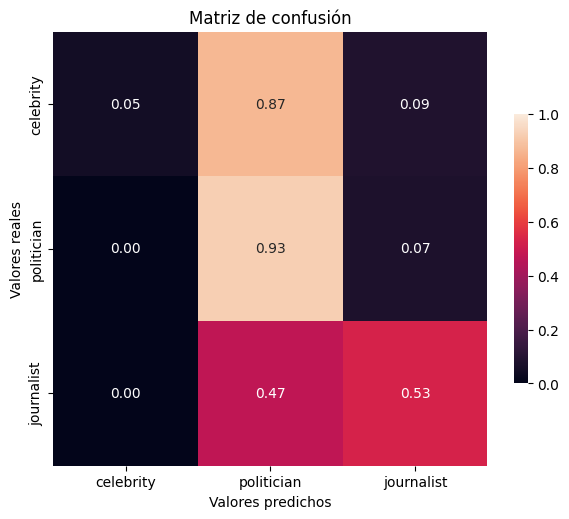

In [20]:
binary_labels = ["celebrity", "politician", "journalist"]
fig = plt.subplots(figsize = (7, 7))
cm_dtc1 = confusion_matrix(y_test, predictions, normalize = "true")
sb.heatmap(cm_dtc1, vmin = 0, vmax = 1, square = True, annot = True, fmt = ".2f", cbar_kws = {"shrink" : 0.5}, xticklabels = binary_labels, yticklabels = binary_labels)
plt.title("Matriz de confusión")
plt.xlabel("Valores predichos")
plt.ylabel("Valores reales")
plt.show()

In [21]:
y_test2=np.array(y_test)
# Step 4: Analyze incorrect predictions

incorrect_indices = [i for i in range(len(y_test2)) if y_test2[i] != predictions[i]]
incorrect_samples = [df_cb.iloc[i]['text'] for i in incorrect_indices]
incorrect_true_labels = [y_test2[i] for i in incorrect_indices]
incorrect_predicted_labels = [predictions[i] for i in incorrect_indices]


c = 0
# Step 5: Investigate the misclassified samples
for sample, true_label, predicted_label in zip(incorrect_samples, incorrect_true_labels, incorrect_predicted_labels):
    # Analyze the misclassified sample and relevant information
    print(f'Sample: {sample}')
    print(f'True Label: {true_label}')
    print(f'Predicted Label: {predicted_label}')
    print("---")
    c = c + 1

Streaming output truncated to the last 5000 lines.
Sample: El lunes en la SER comentaba con Margallo el devenir de la guerra. Me dijo: “Si lo que al final van a pactar es que Ucrania no entre en la OTAN y el estatus del Donbás y Crimea, lo podrían haber pactado en diciembre”. Escribo sobre la OTAN en @user 👇🏻.
True Label: celebrity
Predicted Label: journalist
---
Sample: ¿Hubo irregularidades en el juicio contra [POLITICIAN]? ¿Fue víctima de un montaje? En La Base lo analizamos y mostramos vídeos del juicio. Parece que hay a quien le preocupa que se hable del tema. Aquí tienes el programa. Qué lo vea todo el mundo. Difunde.
True Label: politician
Predicted Label: journalist
---
Sample: ¿Qué se puede hacer para enfrentar el golpe del los 6 magistrados de derechas del Tribunal Constitucional? Aquí lo intento explicar 👇🏻. 📺 [HASHTAG] completo:
True Label: politician
Predicted Label: journalist
---
Sample: Programón de los compañeros de @user sobre la dimensión informativa de la guerra. No